# Text classification with TensorFlow Hub: Movie reviews

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with [TensorFlow Hub](https://tfhub.dev) and Keras.

It uses the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [`tf.keras`](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [`tensorflow_hub`](https://www.tensorflow.org/hub), a library for loading trained models from [TFHub](https://tfhub.dev) in a single line of code. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


## Download the IMDB dataset

The IMDB dataset is available on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [2]:
# Split the training set into 60% and 40% to end up with 15,000 examples for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(name = "imdb_reviews", split = ('train[:60%]', 'train[60%:]', 'test'), as_supervised = True)

2024-02-07 19:02:28.915055: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 1/1 [00:04<00:00,  4.79s/ url]


Dataset imdb_reviews downloaded and prepared to /Users/christopherton/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
len(train_data)

15000

In [4]:
len(validation_data)

10000

In [5]:
len(test_data)

25000

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print first 10 examples.

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
print(train_examples_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

2024-02-07 19:04:13.641681: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Let's also print the first 10 labels.

In [7]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

Build the model
The neural network is created by stacking layers—this requires three main architectural decisions:

How to represent the text?
How many layers to use in the model?
How many hidden units to use for each layer?
In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. Use a pre-trained text embedding as the first layer, which will have three advantages:

You don't have to worry about text preprocessing,
Benefit from transfer learning,
the embedding has a fixed size, so it's simpler to process.
For this example you use a pre-trained text embedding model from TensorFlow Hub called google/nnlm-en-dim50/2.

There are many other pre-trained text embeddings from TFHub that can be used in this tutorial:

google/nnlm-en-dim128/2 - trained with the same NNLM architecture on the same data as google/nnlm-en-dim50/2, but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
google/nnlm-en-dim128-with-normalization/2 - the same as google/nnlm-en-dim128/2, but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
google/universal-sentence-encoder/4 - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.
And many more! Find more text embedding models on TFHub.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: (num_examples, embedding_dimension).

In [8]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape = [], dtype = tf.string, trainable = True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that you are using (google/nnlm-en-dim50/2) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension). For this NNLM model, the embedding_dimension is 50.
This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
The last layer is densely connected with a single output node.
Let's compile the model.

Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), you'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when you are exploring regression problems (say, to predict the price of a house), you'll see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

Train the model
Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the x_train and y_train tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [11]:
history = model.fit(train_data.shuffle(10000).batch(512), epochs = 10, validation_data = validation_data.batch(512), verbose = 1)

Epoch 1/10


30/30 [==============================] - 7s 206ms/step - loss: 0.6593 - accuracy: 0.5315 - val_loss: 0.6021 - val_accuracy: 0.5707
Epoch 2/10
30/30 [==============================] - 6s 199ms/step - loss: 0.5283 - accuracy: 0.7047 - val_loss: 0.4834 - val_accuracy: 0.7441
Epoch 3/10
30/30 [==============================] - 6s 198ms/step - loss: 0.3936 - accuracy: 0.8271 - val_loss: 0.3897 - val_accuracy: 0.8233
Epoch 4/10
30/30 [==============================] - 6s 198ms/step - loss: 0.2854 - accuracy: 0.8875 - val_loss: 0.3374 - val_accuracy: 0.8543
Epoch 5/10
30/30 [==============================] - 6s 199ms/step - loss: 0.2081 - accuracy: 0.9281 - val_loss: 0.3132 - val_accuracy: 0.8630
Epoch 6/10
30/30 [==============================] - 6s 202ms/step - loss: 0.1532 - accuracy: 0.9519 - val_loss: 0.3043 - val_accuracy: 0.8686
Epoch 7/10
30/30 [==============================] - 6s 203ms/step - loss: 0.1120 - accuracy: 0.9684 - val_loss: 0.3058 - val_accuracy: 0.8716
Epoch 8/10
30/30 

Evaluate the model
And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [12]:
results = model.evaluate(test_data.batch(512), verbose = 2)

for name, value in zip(model.metrics_names, results): print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3620 - accuracy: 0.8488 - 2s/epoch - 32ms/step
loss: 0.362
accuracy: 0.849


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

Further reading
For a more general way to work with string inputs and for a more detailed analysis of the progress of accuracy and loss during training, see the Text classification with preprocessed text tutorial.
Try out more text-related tutorials using trained models from TFHub

# Basic classification: Classify images of clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses tf.keras, a high-level API to build and train models in TensorFlow.

Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels).

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The model is tested against the test set, the test_images, and test_labels arrays.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

```
Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [14]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Explore the data
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [15]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [16]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [17]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [18]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [19]:
len(test_labels)

10000

Preprocess the data
The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

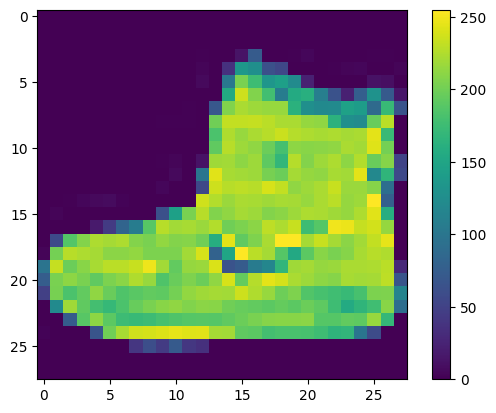

In [20]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [21]:
train_images = train_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

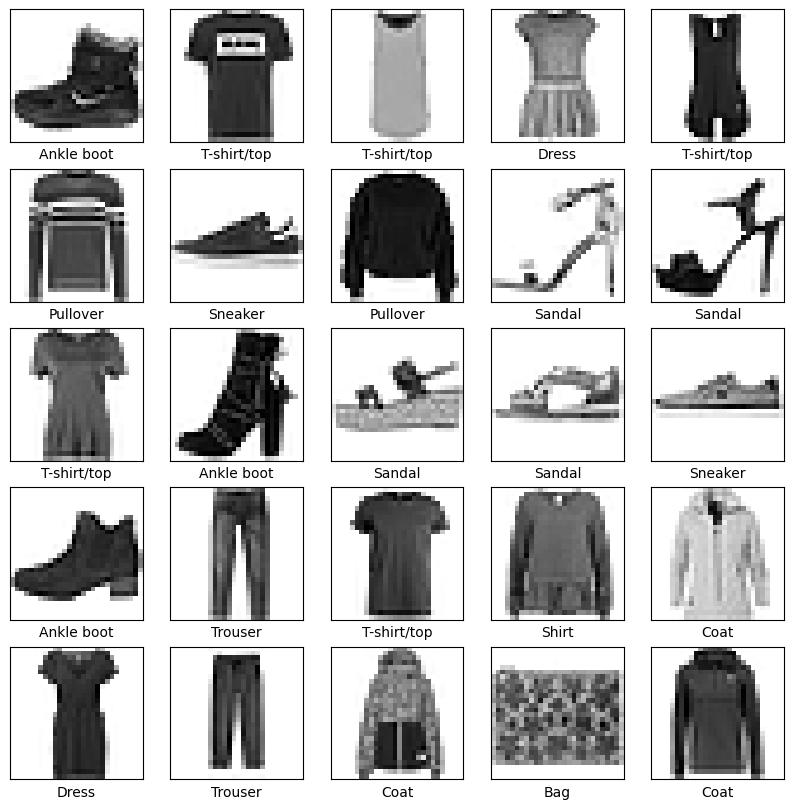

In [22]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Build the model
Building the neural network requires configuring the layers of the model, then compiling the model.

Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

In [23]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (28, 28)), 
                             tf.keras.layers.Dense(128, activation='relu'), 
                             tf.keras.layers.Dense(10)])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
Optimizer —This is how the model is updated based on the data it sees and its loss function.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [24]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

Train the model
Training the neural network model requires the following steps:

Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
The model learns to associate images and labels.
You ask the model to make predictions about a test set—in this example, the test_images array.
Verify that the predictions match the labels from the test_labels array.
Feed the model
To start training, call the model.fit method—so called because it "fits" the model to the training data:

In [25]:
model.fit(train_images, train_labels, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 2s 612us/step - loss: 0.5006 - accuracy: 0.8250
Epoch 2/10
1875/1875 [==============================] - 1s 567us/step - loss: 0.3775 - accuracy: 0.8631
Epoch 3/10
1875/1875 [==============================] - 1s 568us/step - loss: 0.3380 - accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 1s 569us/step - loss: 0.3123 - accuracy: 0.8859
Epoch 5/10
1875/1875 [==============================] - 1s 567us/step - loss: 0.2936 - accuracy: 0.8918
Epoch 6/10
1875/1875 [==============================] - 1s 568us/step - loss: 0.2797 - accuracy: 0.8979
Epoch 7/10
1875/1875 [==============================] - 1s 569us/step - loss: 0.2665 - accuracy: 0.9020
Epoch 8/10
1875/1875 [==============================] - 1s 569us/step - loss: 0.2564 - accuracy: 0.9050
Epoch 9/10
1875/1875 [==============================] - 1s 569us/step - loss: 0.2468 - accuracy: 0.9090
Epoch 10/10
1875/1875 [==============================] - 1s 575u

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

Evaluate accuracy
Next, compare how the model performs on the test dataset:

In [26]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3554 - accuracy: 0.8761 - 184ms/epoch - 589us/step

Test accuracy: 0.8761000037193298


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

Demonstrate overfitting
Strategies to prevent overfitting
Make predictions
With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

In [27]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [28]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 380us/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [29]:
predictions[0]

array([1.1311156e-05, 4.9728871e-10, 1.5243934e-07, 8.1865021e-09,
       6.7141404e-09, 1.1312069e-03, 4.2639232e-07, 9.0926848e-02,
       3.6316538e-07, 9.0792972e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [30]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [31]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [32]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label: color = 'blue'
  else: color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), class_names[true_label]), color = color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Verify predictions
With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

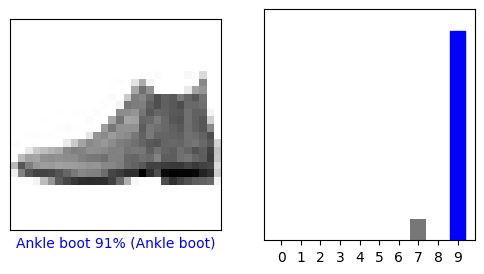

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

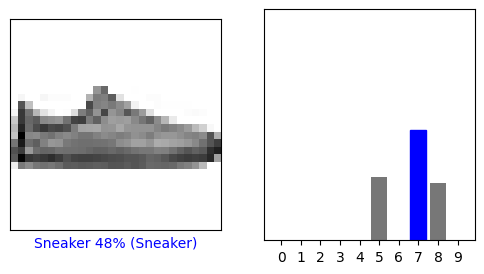

In [34]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

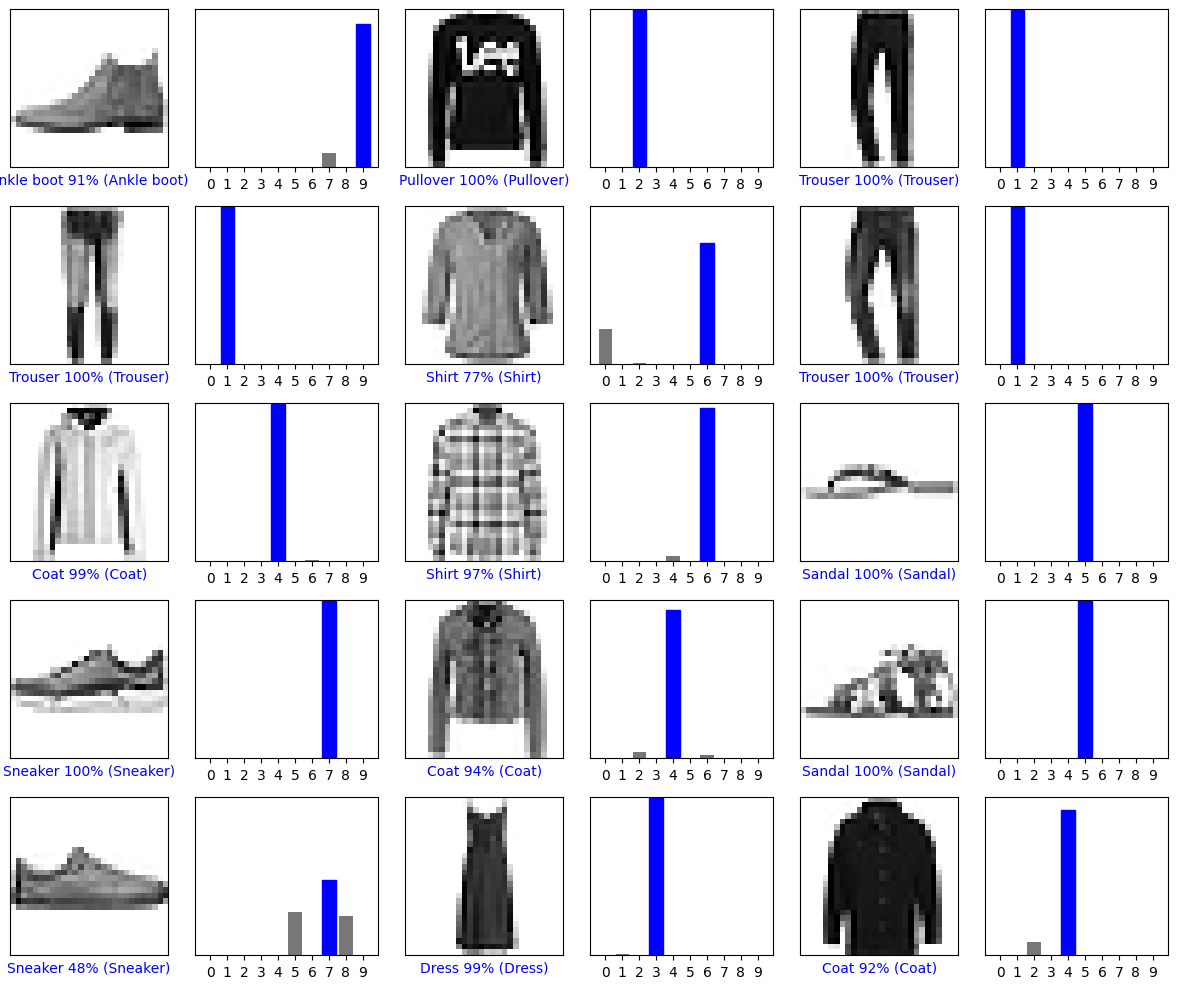

In [35]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Use the trained model
Finally, use the trained model to make a prediction about a single image.

In [36]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [37]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [38]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 11ms/step
[[1.2922775e-05 9.0273485e-14 9.9803919e-01 2.3160960e-09 1.5419857e-03
  2.5339000e-12 4.0597521e-04 6.0974451e-13 5.1076321e-10 3.0624578e-13]]


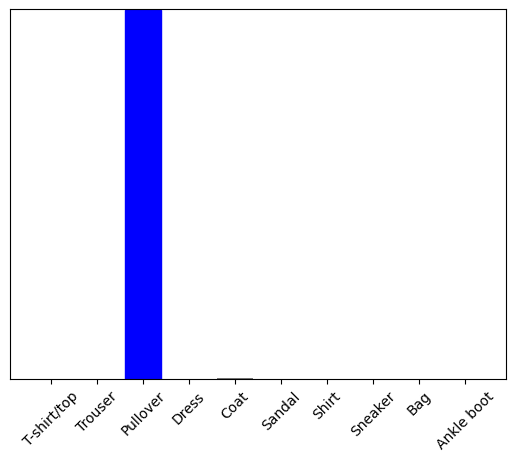

In [39]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [40]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.